# Comparison projections different regions

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import knmi23_module as knmi23

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [5]:
Projects_dir = '/Users/dewilebars/Projects/'
proj_dir = f'{Projects_dir}Project_ProbSLR/Data_Proj/'

fig_out = './'

ProbSLR_dir = f'{Projects_dir}Project_ProbSLR/SLProj/'

## Read input data

In [21]:
proj_data_dir = f'{ProbSLR_dir}/outputs/KNMI23/'

ds = {}

reg_in = ['v19', 'Bonaire_v01', 'Saba_v01', 'global_v01']
reg_out = ['NL', 'Bo', 'Sa', 'Gl']
scen = ['ssp126', 'ssp245', 'ssp585']

for i in range(4):
    for j in range(3):
        ds_ini = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_KNMI23_{scen[j]}_{reg_in[i]}.nc')
        ds[f'{reg_out[i]}_{scen[j]}'] = knmi23.new_ref_period(ds_ini.perc_ts)


In [66]:
ds['NL_ssp126'].proc

<xarray.DataArray 'proc' (proc: 13)>
array(['Global steric', 'Ocean Dynamic Sea Level', 'Inverse barometer',
       'Glaciers', 'Greenland SMB', 'Antarctic SMB', 'Landwater',
       'Antarctic dynamics', 'Greenland dynamics', 'Greenland', 'Antarctica',
       'GIA', 'Total'], dtype=object)
Coordinates:
  * proc     (proc) object 'Global steric' 'Ocean Dynamic Sea Level' ... 'Total'

## Compare total sea level in 2100

### Build a summary dataframe to plot

In [94]:
perc = [5, 17, 50, 83, 95]

all_contrib = {}

In [101]:
contrib_list = ['Global steric', 'Ocean Dynamic Sea Level', 'Glaciers', 
                'Landwater', 'Greenland', 'Antarctica', 'GIA', 'Total']

for contrib in contrib_list:
    summary_df = pd.DataFrame(index=perc)
    summary_df.index.name = 'percentile'
    for i in range(4):
        for j in range(3):
            ds_2100 = []
            for pc in perc:
                ds_2100.append(ds[f'{reg_out[i]}_{scen[j]}'].sel(proc=contrib, 
                                     time=2100.5, percentiles=str(pc)).data.item() )

            summary_df[f'{reg_out[i]}_{scen[j]}'] = ds_2100
            
    all_contrib[contrib] = summary_df

In [103]:
all_contrib['Total']

,NL_ssp126,NL_ssp245,NL_ssp585,Bo_ssp126,Bo_ssp245,Bo_ssp585,Sa_ssp126,Sa_ssp245,Sa_ssp585,Gl_ssp126,Gl_ssp245,Gl_ssp585
percentile,,,,,,,,,,,,
5,26.340032,39.688004,59.038879,31.362076,38.971497,54.837509,29.285343,37.304310,49.872764,30.909195,39.587861,56.518867
17,33.545079,47.399135,67.960296,37.907490,46.739430,64.754218,35.721930,44.789114,60.561557,35.939601,45.441345,65.226582
50,44.498985,59.416967,82.026178,48.191950,59.121361,80.629740,45.884696,56.906335,77.623628,43.952283,55.056926,79.330639
83,58.980237,76.913526,102.887904,63.379120,77.972150,104.008269,61.532486,76.223519,102.102781,56.543812,70.643617,99.474214
95,72.690315,95.388672,123.955309,77.880363,97.840006,126.959278,76.439756,96.555815,126.023588,68.307339,87.017327,118.848700


### Plot

In [105]:
def summary_fig_and_table(ax, df, contrib):
    
    mi = 0.6 # Max color intensity
    
    # Get some pastel shades for the colors
    colors1 = plt.cm.Greens(np.linspace(0, mi, len(df.index)))
    colors2 = plt.cm.Oranges(np.linspace(0, mi, len(df.index)))
    colors3 = plt.cm.Reds(np.linspace(0, mi, len(df.index)))
    
    colors = np.zeros([len(df.columns), len(df.index), 4])
    colors[::3,:,:] = colors1
    colors[1::3,:,:] = colors2
    colors[2::3,:,:] = colors3

    rowColours = plt.cm.Greys(np.linspace(0, mi, len(df.index)))

    # Start from white color
    colors[:,0,:] = 0
    
    index = np.arange(len(df.columns))
    bar_width = 0.6

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(df.columns))

    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(len(df.index)):
        ax.bar(index, 
               df.iloc[row,:]-y_offset, 
               bar_width, 
               bottom=y_offset, 
               color=colors[:,row,:])
        
        y_offset = df.iloc[row,:]
    
    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(2)
    
        
    for row in range(len(df.index)):
        cell_text.append(['%1.0f' % x for x in df.iloc[row]])
    
    ax.set_xlim(-0.5,index[-1]+0.5)
    
    # Add a table at the bottom of the axes
    ax.table(cellText=cell_text[::-1],
             rowLabels=df.index[::-1],
             rowColours=rowColours[::-1],
             colColours=colors[:,2,:],
             colLabels=df.columns.str.split('_').str[1],
             loc='bottom')

    ax.set_xticks([])
    
    for xc in [2.5, 5.5, 8.5]:
        ax.axvline(x=xc, color='grey', linewidth=0.5, linestyle='--')
            
    for yc in np.arange(20,141,40):
        ax.axhline(y=yc, color='grey', linewidth=0.5, linestyle='--')

    # Read scenario names
    list_names = list(df.columns.str.split('_').str[0])
    scen_names = []
    [scen_names.append(x) for x in list_names if x not in scen_names]
        
    # Write the names of scenarios to plot
    xt = [1, 4, 7, 10]
    
    for i in range(4):
        ax.text(xt[i], 145, scen_names[i],
             ha="center", va="center",
             bbox=dict(boxstyle="round", fc='white'))
    
    ax.text(-0.4, 130, contrib)
    
    return ax

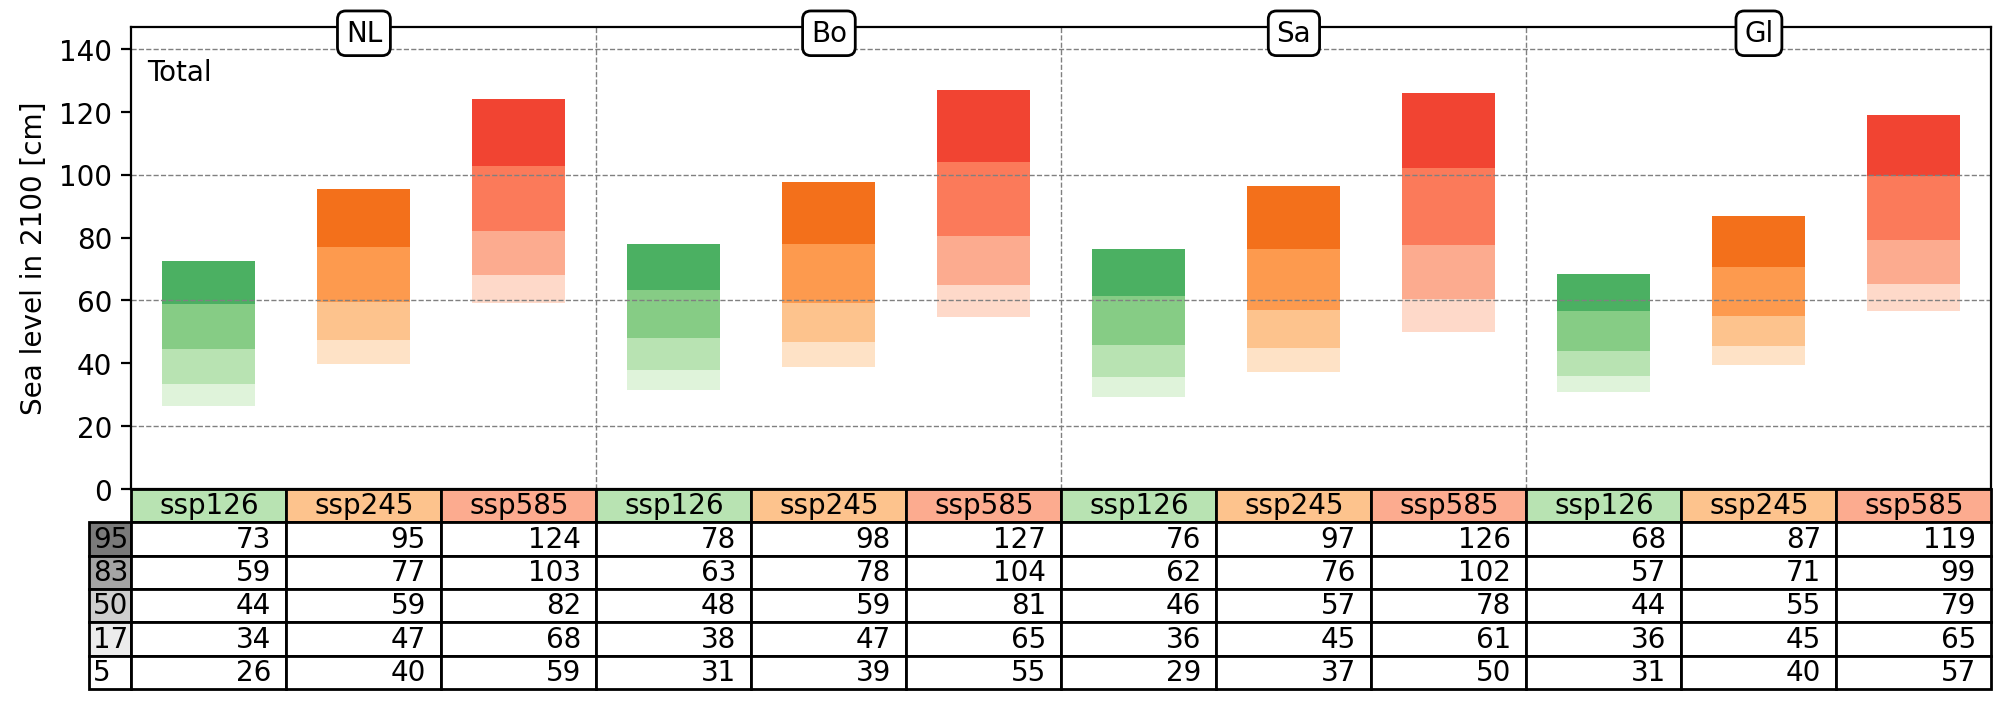

In [107]:
fig, ax = plt.subplots(1, figsize=([12,3]))

ax = summary_fig_and_table(ax, all_contrib['Total'], 'Total')
ax.set_ylabel('Sea level in 2100 [cm]')

plt.savefig(f'./figures/ComparisonRegions2100.pdf', bbox_inches="tight", dpi=150)

## Compare all contributors

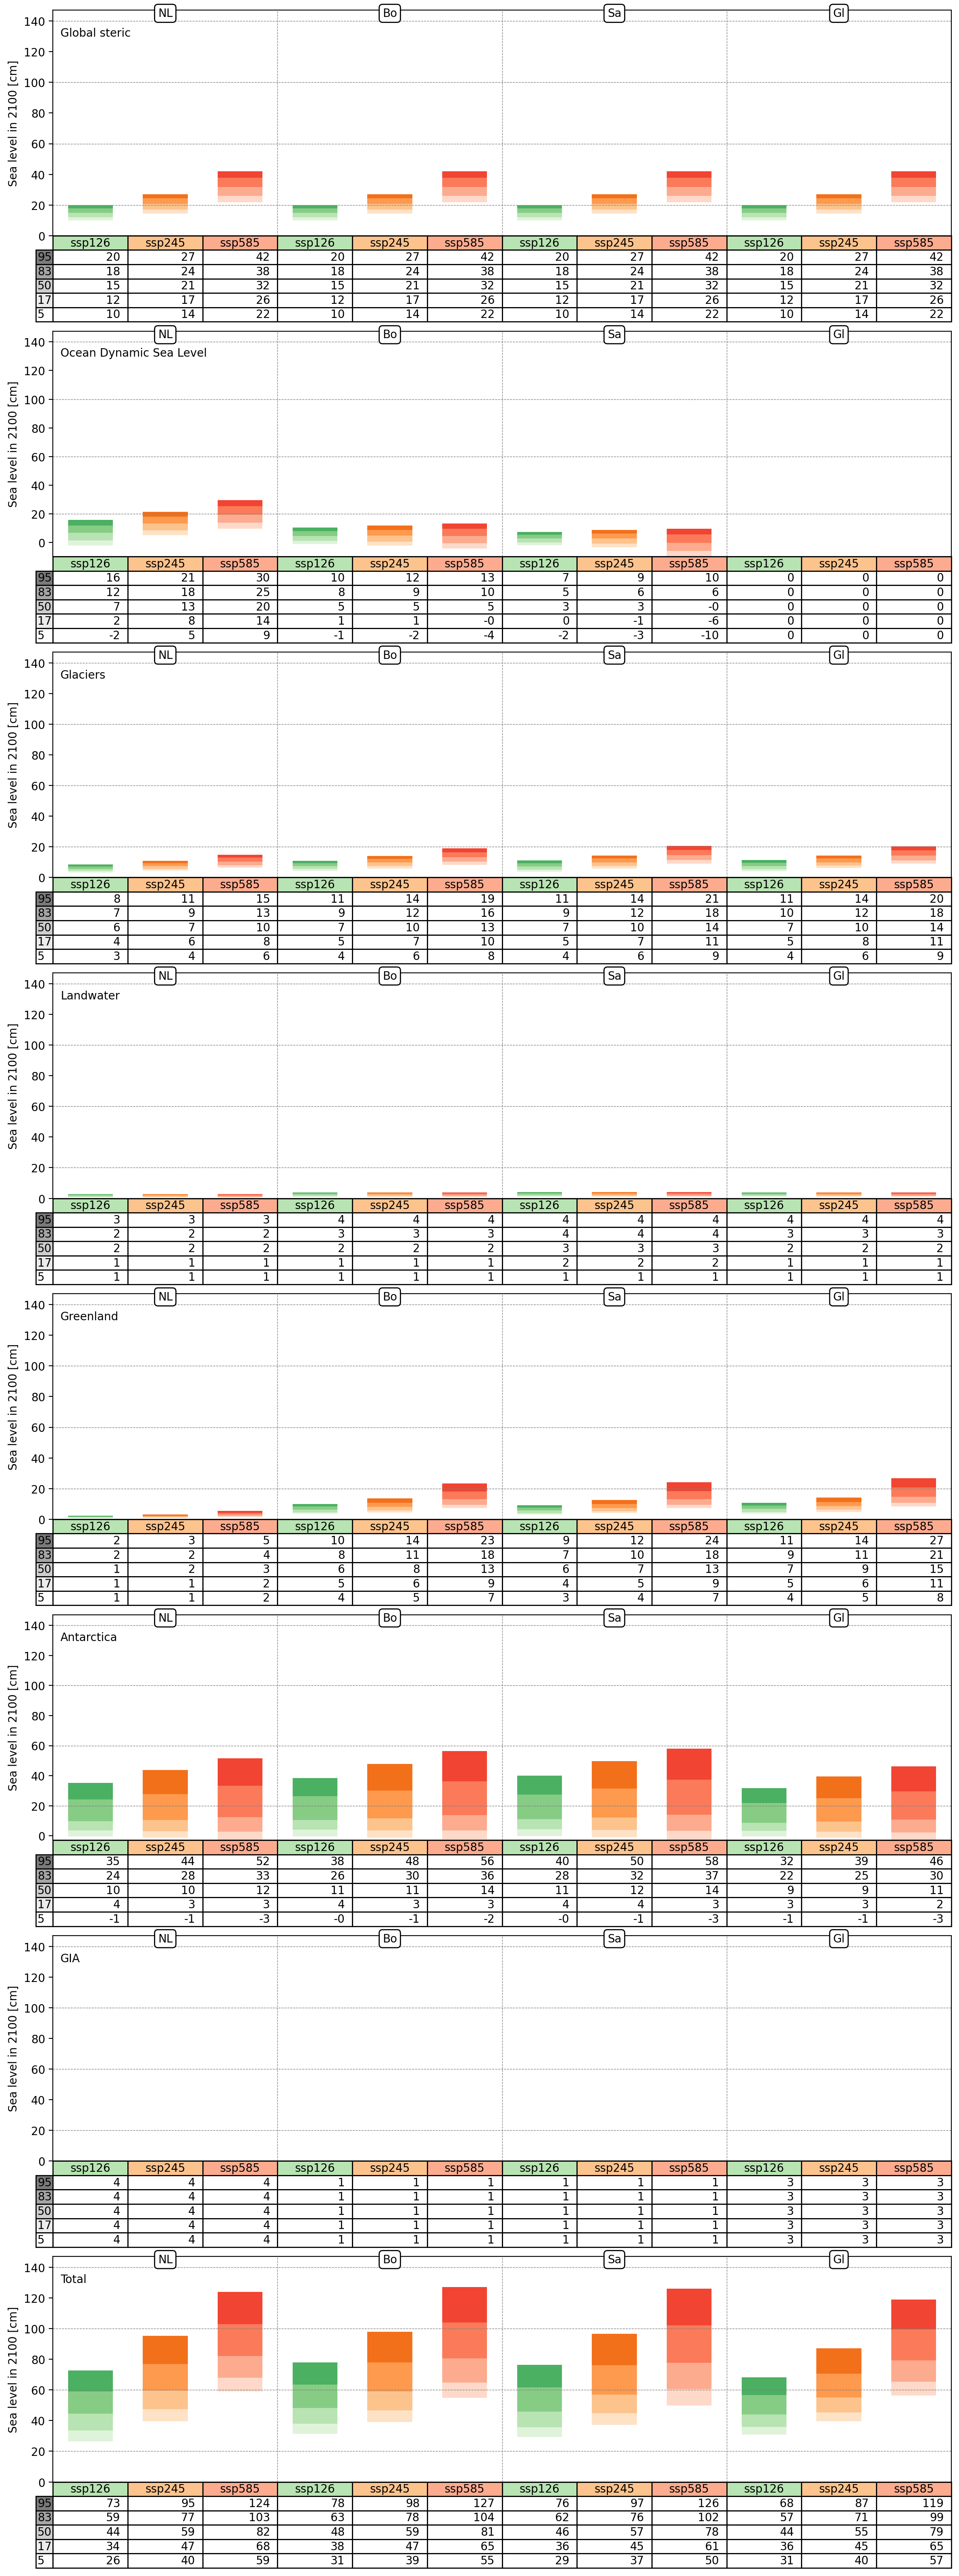

In [109]:
lc = len(contrib_list)

fig, axes = plt.subplots(lc, figsize=([12,4*lc]))

for idx, contrib in enumerate(contrib_list):
    axes[idx] = summary_fig_and_table(axes[idx], all_contrib[contrib], contrib)
    axes[idx].set_ylabel('Sea level in 2100 [cm]')

plt.tight_layout()

plt.savefig(f'./figures/ComparisonRegionsAllContrib2100.pdf', bbox_inches="tight", dpi=150)